In [1]:
from nltk.tokenize import RegexpTokenizer
import sys
import re
import numpy as np
import pandas as pd
import math
import random

In [2]:
tokenizer = RegexpTokenizer(r'\w+')

In [3]:
def tokenizedInput(inputFileName,tokenize=True):
    cleaned_list=[]
    with open(inputFileName) as f:
        docs = f.readlines()

    for doc in docs:
        raw=None
        if(tokenize==True):
            raw = tokenizer.tokenize(doc)
        else:
            raw=doc
        cleaned_list.append(raw)
    
    return cleaned_list


In [4]:
def tokenizedInput_WithNGrams(inputFileName,grams=1):
    cleaned_list=[]
    with open(inputFileName) as f:
        docs = f.readlines()

    for doc in docs:
        raw2=[]
        raw = tokenizer.tokenize(doc)
        leng=len(raw)
        for k in range(grams-1,leng,1):
            new_token=""
            for l in range(k-grams+1,k+1,1):
                new_token+=" "+raw[l]
            raw2.append(new_token)
        cleaned_list.append(raw2+raw)
    
    return cleaned_list

In [5]:
# x_train=tokenizedInput_WithNGrams('Dataset/Stem/toy',grams=2)
# y_train=tokenizedInput('Dataset/imdb/imdb_train_labels.txt',tokenize=False)
# y_train=list(map(int,y_train))


In [6]:
# print ((x_train[0]))

In [7]:
class NaiveBayes:
    
    def __init__(self,x,y,laplace_smoother=1):
        self.x=list(x)
        self.y=list(y)
        self.laplace_smoother=laplace_smoother
        self.distinct_x=0
        self.distinct_y=0
        self.instances=len(y)
        self.x_dict={}
        self.vocabulary={}
        self.y_dict={}
        self.revMapy={}
        self.wordsInClass=[]
        self.instancesInClass=[]
    
    def calculateParameters(self):
#         classes=np.unique(self.npy)
        counter=0
        for i in range(self.instances):
            feature_vector=self.x[i]
            feature_class=self.y[i]
            mapped_class=counter
            
            if(feature_class in self.y_dict):
                mapped_class=self.y_dict[feature_class]
            else:
                self.revMapy[counter]=feature_class
                self.y_dict[feature_class]=counter
                self.wordsInClass.append(0)
                self.instancesInClass.append(0)
                counter+=1
            
            self.instancesInClass[mapped_class]+=1
            
            for words in feature_vector:
                if(words in self.vocabulary):
                    self.vocabulary[words]+=1
                else:
                    self.vocabulary[words]=1
                
                key=(words,mapped_class)
                self.wordsInClass[mapped_class]+=1
                
                if(key in self.x_dict):
                    self.x_dict[key]+=1
                else:
                    self.x_dict[key]=1
            
        self.distinct_x=len(self.vocabulary)
        self.distinct_y=len(self.y_dict)
#         self.printParameters()

    def purge(self,threshold=7):
        
        emp_lis=[]
        
        for key,value in self.vocabulary.items():
            if(value<threshold and len(tokenizer.tokenize(key))>1):
                self.distinct_x-=1
                emp_lis.append(key)
                for labels in range(self.distinct_y):
                    new_key=(key,labels)
                    if(new_key in self.x_dict):
                        count=self.x_dict[new_key]
                        del self.x_dict[new_key]
                        self.wordsInClass[labels]-=count
        
        for words in emp_lis:
            del self.vocabulary[words]
    
    def getLogPrior(self,label):
        return math.log(float(self.instancesInClass[label])/self.instances)
    
    def getLogProb(self,attribute,label):
        
        occurences=0
        key=(attribute,label)
        
        if key in self.x_dict:
            occurences=self.x_dict[key]
        
        occurences+=self.laplace_smoother

        total_occurences_in_class=self.wordsInClass[label]
        total_occurences_in_class+=self.distinct_x*self.laplace_smoother
        
#         if(occurences<=0 || total_occurences_in_class<=0):
            
        return math.log(float(occurences)/total_occurences_in_class)
        
    def getClass(self,x):
        max_log_prob=-1e9
        label=-1
        
        for i in range(self.distinct_y):
            log_prob_x_given_y=0
            
            for attributes in x:
                log_prob_x_given_y+=self.getLogProb(attributes,i)
            
            log_prob_x=log_prob_x_given_y+self.getLogPrior(i)
            
            if(log_prob_x>max_log_prob):
                max_log_prob=log_prob_x
                label=self.revMapy[i]
            
        return label
    
    def ConfusionMatrix(self,y,predy):
        confusion = [ [0]*self.distinct_y for _ in range(self.distinct_y) ]
        
        tests=len(y)
        
        for i in range(tests):
            confusion[self.y_dict[predy[i]]][self.y_dict[y[i]]]+=1
        
        for i,ii in self.y_dict.items():
            for j,jj in self.y_dict.items():
                print("%5d"%(confusion[ii][jj]),end=' ')
            print()
        
        
    def getAccuracy(self,x,y,printConfusionMatrix=False):
        total_tests=len(y)
        passed_tests=0
        prediction_list=[]
        
        for i in range(total_tests):
            xi=x[i]
            yi=y[i]
            
#             if y[i] in self.y_dict:
#                 pass
#             else:
#                 continue
            pred_yi=self.getClass(xi)
            prediction_list.append(pred_yi)
            if(pred_yi==yi):
                passed_tests+=1
        
        if(printConfusionMatrix==True):
            self.ConfusionMatrix(y,pred_yi)
                
        return [prediction_list,(float(passed_tests))/total_tests]
    
    def getAccuracyRandomPredict(self,x,y):
        
        average_over=10
        total_accuracy=0
        
        for i in range(average_over):
            
            total_tests=len(y)
            passed_tests=0

            for i in range(total_tests):
                yi=y[i]

                pred_yi=random.randint(0,self.distinct_y-1)
                pred_yi=self.revMapy[pred_yi]

                if(pred_yi==yi):
                    passed_tests+=1

            total_accuracy+=(float(passed_tests))/total_tests
        
        return total_accuracy/average_over
    
    def getAccuracyMajorityPredictor(self,x,y):
        max_occ=-1
        majority_class=-1
        total_tests=len(y)
        passed_tests=0        
        
        for i in range(self.distinct_y):
            if(max_occ<self.instancesInClass[i]):
                max_occ=self.instancesInClass[i]
                majority_class=i
        
        if(majority_class==-1):
            return 0
        
        majority_class=self.revMapy[majority_class]
        
        for yi in y:
            if(yi==majority_class):
                passed_tests+=1
                
        return (float(passed_tests))/total_tests       

    def printParameters(self):
        print("Vocabulary Size:",self.distinct_x)
        print("Classes:",self.distinct_y)
        print("X_Y's:",len(self.x_dict))
        
        print("Mapped Classes:", self.y_dict)
        
        print("Instances In Mapped class:",end='')
        
        for counts in self.instancesInClass:
            print(counts,end=' ')
        
        print("")
        print("Words In Mapped class:",end='')
        
        for counts in self.wordsInClass:
            print(counts,end=' ')
        
        print("")
        

In [8]:
def augmentation(x_train,y_train):
    x=[]
    y=[]
    
    instance=len(y_train)
    lis1=[2,3,4]
    lis2=[7,8,9]
    
    for i in range(instance):
        x.append(x_train[i])
        y.append(y_train[i])
        
        if(y_train[i]==1):
            x.append(x_train[i])
            y.append(lis1[random.randint(0,2)])
            x.append(x_train[i])
            y.append(lis1[random.randint(0,2)])
#             x.append(x_train[i])
#             y.append(lis1[random.randint(0,2)])
        
        if(y_train[i]==10):
            x.append(x_train[i])
            y.append(lis2[random.randint(0,2)])
            x.append(x_train[i])
            y.append(lis2[random.randint(0,2)])
#             x.append(x_train[i])
#             y.append(lis2[random.randint(0,2)])
            
    return (x,y)
    

In [62]:
# x_train=tokenizedInput('Dataset/Stem/imdb_train_text.txt',grams=2)
x_train=tokenizedInput('Dataset/Clean1/imdb_train_text.txt')
y_train=tokenizedInput('Dataset/imdb/imdb_train_labels.txt',tokenize=False)
y_train=list(map(int,y_train))
# (x_train,y_train)=augmentation(x_train,y_train)
# x_test=tokenizedInput('Dataset/Stem/imdb_test_text.txt',grams=2)
x_test=tokenizedInput('Dataset/Clean1/imdb_test_text.txt')
y_test=tokenizedInput('Dataset/imdb/imdb_test_labels.txt',tokenize=False)
y_test=list(map(int,y_test))

In [63]:
print(len(y_train))

25000


In [64]:
NaiveBayesClassifier=NaiveBayes(x=x_train,y=y_train)
NaiveBayesClassifier.calculateParameters()
print (len(NaiveBayesClassifier.x_dict))
print(NaiveBayesClassifier.distinct_x)
print(len(NaiveBayesClassifier.vocabulary))

241067
74481
74481


In [65]:
# NaiveBayesClassifier.purge(threshold=7)
print(len(NaiveBayesClassifier.x_dict))
print(NaiveBayesClassifier.distinct_x)
print(len(NaiveBayesClassifier.vocabulary))

241067
74481
74481


In [66]:
NaiveBayesClassifier.getAccuracyMajorityPredictor(x_test,y_test)

0.20088

In [67]:
NaiveBayesClassifier.getAccuracyRandomPredict(x_test,y_test)

0.123592

In [68]:
[a,b]=(NaiveBayesClassifier.getAccuracy(x_test,y_test,printConfusionMatrix=False))
print (b)
# print(NaiveBayesClassifier.ConfusionMatrix(a,y_test))

0.38468


In [18]:
NaiveBayesClassifier.ConfusionMatrix(y_test,a)

 4147  1494  1261   924   340   354   281   595 
  128    79   107    75    23    28    18    36 
  198   209   278   298   110    96    46    71 
  252   285   503   666   288   209   116   137 
   43    65   116   214   411   324   163   208 
   71    45   105   204   490   686   430   532 
   37    13    24    41   127   213   164   249 
  146   112   147   213   518   940  1126  3171 


In [101]:
# NaiveBayesClassifier.ConfusionMatrix(y_test,a)

In [251]:
NaiveBayesClassifier.y_dict

{1: 7, 2: 6, 3: 4, 4: 5, 7: 2, 8: 1, 9: 3, 10: 0}

In [97]:
x_train2=tokenizedInput('Dataset/Stem/imdb_train_text.txt')
y_train2=tokenizedInput('Dataset/imdb/imdb_train_labels.txt',tokenize=False)
y_train2=list(map(int,y_train2))
(x_train2,y_train2)=augmentation(x_train2,y_train2)
x_test2=tokenizedInput('Dataset/imdb/imdb_test_text.txt')
y_test2=tokenizedInput('Dataset/imdb/imdb_test_labels.txt',tokenize=False)
y_test2=list(map(int,y_test2))

In [98]:
NaiveBayesClassifier2=NaiveBayes(x=x_train2,y=y_train2)
NaiveBayesClassifier2.calculateParameters()
# print (sum(NaiveBayesClassifier2.wordsInClass))

In [99]:
[a2,b2]=(NaiveBayesClassifier2.getAccuracy(x_test2,y_test2,printConfusionMatrix=False))
print (b2)

0.24196


In [41]:
# NaiveBayesClassifier.ConfusionMatrix(y_test2,a2)

In [33]:
# x_train3=tokenizedInput_WithNGrams('Dataset/Stem/imdb_train_text.txt',grams=3)
# y_train3=tokenizedInput('Dataset/imdb/imdb_train_labels.txt',tokenize=False)
# y_train3=list(map(int,y_train3))
# x_test3=tokenizedInput_WithNGrams('Dataset/imdb/imdb_test_text.txt',grams=3)
# y_test3=tokenizedInput('Dataset/imdb/imdb_test_labels.txt',tokenize=False)
# y_test3=list(map(int,y_test3))

In [34]:
# print (len(NaiveBayesClassifier2.x_dict))

2151085


In [69]:
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools


In [70]:
def getConfusionMatrix(y1,y2):
    conf=np.zeros((8,8))
    dd={1:0,2:1,3:2,4:3,7:4,8:5,9:6,10:7}
    
    ins=len(y1)
    
    for i in range(ins):
        conf[dd[y1[i]],dd[y2[i]]]+=1
    
    return conf

In [71]:
confuse=getConfusionMatrix(y_test,a)

In [72]:
confuse


array([[4266.,   90.,  155.,  260.,   36.,   63.,   18.,  134.],
       [1583.,   51.,  187.,  273.,   55.,   54.,    5.,   94.],
       [1360.,   58.,  233.,  489.,  126.,  119.,   14.,  142.],
       [1032.,   47.,  218.,  674.,  222.,  227.,   28.,  187.],
       [ 400.,    9.,   80.,  263.,  427.,  517.,   74.,  537.],
       [ 422.,   13.,   63.,  166.,  317.,  715.,  131., 1023.],
       [ 333.,    6.,   23.,   96.,  155.,  466.,  124., 1141.],
       [ 796.,   12.,   45.,  102.,  180.,  558.,  179., 3127.]])

In [73]:
class_names=np.array([1,2,3,4,7,8,9,10])

Confusion matrix, without normalization
[[4266   90  155  260   36   63   18  134]
 [1583   51  187  273   55   54    5   94]
 [1360   58  233  489  126  119   14  142]
 [1032   47  218  674  222  227   28  187]
 [ 400    9   80  263  427  517   74  537]
 [ 422   13   63  166  317  715  131 1023]
 [ 333    6   23   96  155  466  124 1141]
 [ 796   12   45  102  180  558  179 3127]]


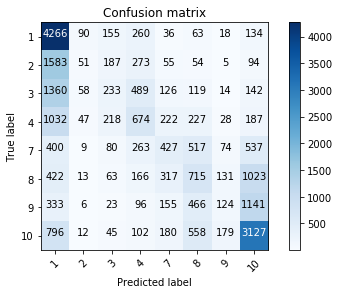

In [74]:
plt.figure()
plot_confusion_matrix(confuse.astype(int), classes=class_names,
                      title='Confusion matrix')
plt.show()

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [58]:
x_train1=tokenizedInput('Dataset/imdb/imdb_train_text.txt')
y_train1=tokenizedInput('Dataset/imdb/imdb_train_labels.txt',tokenize=False)
y_train1=list(map(int,y_train1))
x_test1=tokenizedInput('Dataset/imdb/imdb_test_text.txt')
y_test1=tokenizedInput('Dataset/imdb/imdb_test_labels.txt',tokenize=False)
y_test1=list(map(int,y_test1))

In [59]:
NaiveBayesClassifier1=NaiveBayes(x=x_train1,y=y_train1)
NaiveBayesClassifier1.calculateParameters()
print (len(NaiveBayesClassifier1.x_dict))

284961


In [60]:
[a1,b1]=(NaiveBayesClassifier1.getAccuracy(x_test1,y_test1,printConfusionMatrix=False))
print (b1)

0.38408


In [61]:
NaiveBayesClassifier1.ConfusionMatrix(y_test1,a1)

 4319  1630  1416  1101   430   441   341   809 
   71    33    36    28     3    12     5     8 
  131   157   198   181    62    54    17    35 
  237   257   488   675   246   149    85   101 
   43    47   115   200   378   278   142   155 
   69    61   127   230   560   730   468   569 
    9     9     9    22    60   101    95   148 
  143   108   152   198   568  1085  1191  3174 


In [ ]:
# x_train_uni_bi=tokenizedInput_WithNGrams('Dataset/Stem/imdb_train_text.txt',grams=2)
# y_train_uni_bi=tokenizedInput('Dataset/imdb/imdb_train_labels.txt',tokenize=False)
# y_train_uni_bi=list(map(int,y_train_uni_bi))
# x_test_uni_bi=tokenizedInput_WithNGrams('Dataset/Stem/imdb_test_text.txt',grams=2)
# y_test_uni_bi=tokenizedInput('Dataset/imdb/imdb_test_labels.txt',tokenize=False)
# y_test_uni_bi=list(map(int,y_test1))